# Basic Model

In [1]:
%pwd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import utils
%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


In [2]:
base_path = '/home/ubuntu/data/statefarm/imags/' #imags/samples
train_path = base_path + 'train'
val_path = base_path + 'valid'
test_path = base_path + 'test'
weight_path = '/home/ubuntu/data/weights/statefarm/'
sub_path = '/home/ubuntu/fastai_course/neilz/part1/sub/statefarm/'

In [3]:
import vgg16; reload(vgg16)

<module 'vgg16' from 'vgg16.pyc'>

In [13]:
vggm = vgg16.Vgg16()

vgg16.py:100: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  model.add(Conv2D(filters, 3, 3, activation='relu'))
vgg16.py:100: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  model.add(Conv2D(filters, 3, 3, activation='relu'))
vgg16.py:100: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
  model.add(Conv2D(filters, 3, 3, activation='relu'))
vgg16.py:100: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), activation="relu")`
  model.add(Conv2D(filters, 3, 3, activation='relu'))


In [5]:
vggm.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 114, 114)      0         
__________

In [30]:
#Remove dense layers, only keep convolution layers
vggm.model.pop() #dense6
vggm.model.pop() #dropout4
vggm.model.pop() #dense5
vggm.model.pop() #dropout3
vggm.model.pop() #dense4
vggm.compile() 
vggm.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_14 (ZeroPaddi (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_15 (ZeroPaddi (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_16 (ZeroPaddi (None, 64, 114, 114)      0         
__________

In [20]:
#Use train data to get convolution results
batch_size = 60
train_batches, train_predictions = vggm.test(train_path, batch_size)
utils.save_array(weight_path + '/statefarm_conv_res', train_predictions)

Found 17943 images belonging to 10 classes.


In [32]:
print(train_predictions[0][:100])

[  0.       0.       0.       0.       0.       0.       1.8962   0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.
  35.4123   0.      43.7633   0.       0.       0.       0.       0.       5.4461   0.       0.       0.
   0.       0.       0.      13.4655  11.5091   0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.       0.
   0.      16.0039   0.       0.       0.    ]


In [33]:
batch_size = 60
val_batches, val_predictions = vggm.test(val_path, batch_size)
test_batches, test_predictions = vggm.test(test_path, batch_size)
utils.save_array(weight_path + '/statefarm_conv_val', val_predictions)
utils.save_array(weight_path + '/statefarm_conv_test', test_predictions)

Found 4481 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.


In [34]:
print(test_predictions.shape)

(79726, 25088)


# Apply Pre-Trained Convolution Layers

In [4]:
import utils
mid_train_data = utils.load_array(weight_path + '/statefarm_conv_res')
mid_val_data = utils.load_array(weight_path + '/statefarm_conv_val')
mid_test_data = utils.load_array(weight_path + '/statefarm_conv_test')

In [5]:
print(mid_train_data.shape)

(17943, 25088)


In [5]:
#Construct a new model with just FCBs and using the convoluation results from Vgg16 as input
#I want to overfit the train data first, so I use 2 dense layers total 4096*4096+4096 (bias) parameters without dropout
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
lr = 0.001
statefarm_model = Sequential()
#statefarm_model.add(BatchNormalization(axis=1, input_shape=(25088,)))
statefarm_model.add(Dense(1, activation='relu', input_shape=(25088,)))
#statefarm_model.add(Dropout(0.5)) 
#statefarm_model.add(Dense(256, activation='relu'))
#statefarm_model.add(Dropout(0.5))
statefarm_model.add(Dense(10, activation='softmax'))
statefarm_model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
#If I don't add Dropout layers, I got almost constant train and validation accuracy, 
#which are pretty low, close to zero. Why this is the case? 

In [7]:
val_classes, train_classes, val_labels, train_labels, \
        val_filenames, train_filenames, test_filenames = utils.get_classes(base_path)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.


In [8]:
print(mid_train_data[0])

[ 0.  0.  0. ...,  0.  0.  0.]


In [9]:
statefarm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 25089     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                20        
Total params: 25,109
Trainable params: 25,109
Non-trainable params: 0
_________________________________________________________________


In [47]:
from keras import backend as K
K.set_value(statefarm_model.optimizer.lr, lr*0.001)
print(statefarm_model.optimizer.get_config())
statefarm_model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])

{'beta_1': 0.8999999761581421, 'epsilon': 1e-08, 'beta_2': 0.9990000128746033, 'lr': 9.999999974752427e-07, 'decay': 0.0}


In [65]:
from keras.callbacks import ModelCheckpoint
#Need create train batch and validation batch
batch_size = 100

saved_weights_path = weight_path + '/fcn_epoch_{epoch:02d}-valloss_{val_loss:.2f}.hdf5'
mcp = ModelCheckpoint(saved_weights_path, monitor='val_loss', save_weights_only=True, mode='auto', period=10)
call_backs = [mcp]
epochs = 200
h = statefarm_model.fit(mid_train_data, train_labels, epochs=epochs, validation_data=(mid_val_data, val_labels), batch_size=batch_size, shuffle=True, callbacks=call_backs)
#statefarm_model.fit(mid_train_data, train_labels, epochs = epochs,validation_data=(mid_val_data, val_labels), batch_size=batch_size )

Train on 17943 samples, validate on 4481 samples
Epoch 1/200
17943/17943 [==============================] - 2s 99us/step - loss: 2.3096 - acc: 0.1078 - val_loss: 2.3006 - val_acc: 0.1109
Epoch 2/200
17943/17943 [==============================] - 2s 99us/step - loss: 2.3004 - acc: 0.1110 - val_loss: 2.3001 - val_acc: 0.1109
Epoch 3/200
17943/17943 [==============================] - 2s 103us/step - loss: 2.3001 - acc: 0.1110 - val_loss: 2.2999 - val_acc: 0.1109
Epoch 4/200
17943/17943 [==============================] - 2s 105us/step - loss: 2.3000 - acc: 0.1110 - val_loss: 2.2998 - val_acc: 0.1109
Epoch 5/200
17943/17943 [==============================] - 2s 102us/step - loss: 2.2999 - acc: 0.1110 - val_loss: 2.2998 - val_acc: 0.1109
Epoch 6/200
17943/17943 [==============================] - 2s 98us/step - loss: 2.2999 - acc: 0.1110 - val_loss: 2.2998 - val_acc: 0.1109
Epoch 7/200
17943/17943 [==============================] - 2s 96us/step - loss: 2.2999 - acc: 0.1110 - val_loss: 2.2998 

In [10]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
weight_path = '/home/ubuntu/data/weights/statefarm/'
lr = 0.001
testm = Sequential()
#testm.add(BatchNormalization(axis=1, input_shape=(25088,)))
testm.add(Dense(1, activation='relu', input_shape=(25088,)))
#testm.add(Dropout(0.5))
#testm.add(Dense(256, activation='relu'))
#testm.add(Dropout(0.5))
testm.add(Dense(10, activation='softmax'))
testm.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
testm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1)                 25089     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                20        
Total params: 25,109
Trainable params: 25,109
Non-trainable params: 0
_________________________________________________________________


In [20]:
import numpy as np
from scipy import stats
a = range(1,20)
stats.describe(a)
print(a)
sum(1 for i in a if i > 5)
s = 'dense/kernel'
s.split("/")[1]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


'kernel'

In [4]:
import utils
mid_train_data = utils.load_array(weight_path + '/statefarm_conv_res')
wp = weight_path + '/fcn_epoch_200-valloss_2.30.hdf5'
print(wp)
testm.load_weights(wp)

/home/ubuntu/data/weights/statefarm//fcn_epoch_150-valloss_2.30.hdf5
Number of layers = 2
Working on layer <keras.layers.core.Dense object at 0x7f4eb828f7d0>
Working on layer <keras.layers.core.Dense object at 0x7f4e761aa410>
Layer name : dense_16
Layer name : dense_17
Layer name 2: dense_16
Original_keras_version : 2.1.1
layer class name: Dense
weight_values type: <type 'list'>
symbolic_weights type: <type 'list'>
wn = dense_1/kernel, wv = <HDF5 dataset "kernel": shape (25088, 1), type "<f4">, wv type = <class 'h5py._hl.dataset.Dataset'>, wv shape= (25088, 1)
Path to output: ./dense0_kernel.csv
wn = dense_1/bias, wv = <HDF5 dataset "bias": shape (1,), type "<f4">, wv type = <class 'h5py._hl.dataset.Dataset'>, wv shape= (1,)
Path to output: ./dense0_bias.csv
Layer name 2: dense_17
Original_keras_version : 2.1.1
layer class name: Dense
weight_values type: <type 'list'>
symbolic_weights type: <type 'list'>
wn = dense_2/kernel, wv = <HDF5 dataset "kernel": shape (1, 10), type "<f4">, wv t

In [44]:
import pandas as pd
import numpy as np
epochs = [10, 50, 100, 150, 200]
#epochs = [10]
#kernels0, kernels1 = [], []
#bias0, bias1 = [], []
#acts = []
df_kernels0 = pd.DataFrame()
df_kernels1 = pd.DataFrame()
df_bias0 = pd.DataFrame()
df_bias1 = pd.DataFrame()
df_acts = pd.DataFrame()
for epoch in epochs:
    print ("Working on epoch %d"%epoch)
    out_path = '/home/ubuntu/fastai_course/neilz/part1/epoch' + str(epoch)
    #Hidden Layer with 1 neuron
    df0_kernel = pd.read_csv(out_path + '/dense0_kernel.csv', header=0)
    df0_bias = pd.read_csv(out_path + '/dense0_bias.csv', header=0)
    #Softmax layer with 10 outputs
    df1_kernel = pd.read_csv(out_path + '/dense1_kernel.csv', header=0)
    df1_bias = pd.read_csv(out_path + '/dense1_bias.csv', header=0)
    
    #kernels0.append(df0_kernel)
    #kernels1.append(df1_kernel)
    #bias0.append(df0_bias)
    #bias1.append(df1_bias)
    col = 'epoch' + str(epoch)
    df_kernels0[col] = df0_kernel['Value']
    df_kernels1[col] = df1_kernel['Value']
    df_bias0[col] = df0_bias['Value']
    df_bias1[col] = df1_bias['Value']
    tmp_act = []
    for td in mid_train_data:
        act = sum(td * np.array(df0_kernel['Value'])) + df0_bias['Value'][0] #Compute activation
        tmp_act.append(act)
    df_act = pd.DataFrame(tmp_act)
    #acts.append(df_act)
    df_acts[col] = tmp_act

Working on epoch 10
Working on epoch 50
Working on epoch 100
Working on epoch 150
Working on epoch 200


In [46]:
df_bias0.()

epoch10   epoch50  epoch100  epoch150  epoch200
0 -0.006006 -0.006006 -0.006006 -0.006006 -0.006006

In [74]:
df_kernels0

epoch10   epoch50  epoch100  epoch150  epoch200
0      0.000393  0.009102  0.009102  0.009102  0.009102
1     -0.003148 -0.012515 -0.012515 -0.012515 -0.012515
2      0.014883  0.008886  0.008886  0.008886  0.008886
3     -0.006520 -0.011233 -0.011233 -0.011233 -0.011233
4      0.000030  0.002092  0.002092  0.002092  0.002092
5     -0.007984  0.000499  0.000499  0.000499  0.000499
6     -0.008906 -0.001509 -0.001509 -0.001509 -0.001509
7      0.006377 -0.012240 -0.012240 -0.012240 -0.012240
8      0.001692 -0.015688 -0.015688 -0.015688 -0.015688
9     -0.013706 -0.014463 -0.014463 -0.014463 -0.014463
10     0.008444  0.010740  0.010740  0.010740  0.010740
11    -0.013401  0.006598  0.006598  0.006598  0.006598
12    -0.011020 -0.001645 -0.001645 -0.001645 -0.001645
13    -0.000044 -0.010206 -0.010206 -0.010206 -0.010206
14    -0.015757  0.006504  0.006504  0.006504  0.006504
15    -0.000970 -0.008399 -0.008399 -0.008399 -0.008399
16    -0.002969 -0.010951 -0.010951 -0.010951 -0.010951
17    -0.018452 -0.013180 -0.013180 -0.013180 -0.013180
18    -0.018256 -0.016575 -0.016575 -0.016575 -0.016575
19    -0.004172 -0.004512 -0.004512 -0.004512 -0.004512
20    -0.015744  0.004615  0.004615  0.004615  0.004615
21    -0.008499 -0.011860 -0.011860 -0.011860 -0.011860
22     0.007790 -0.004799 -0.004799 -0.004799 -0.004799
23     0.005690 -0.015647 -0.015647 -0.015647 -0.015647
24    -0.006578 -0.014354 -0.014354 -0.014354 -0.014354
25    -0.015482 -0.003018 -0.003018 -0.003018 -0.003018
26    -0.008293  0.003138  0.003138  0.003138  0.003138
27     0.001962 -0.005380 -0.005380 -0.005380 -0.005380
28    -0.013403 -0.011738 -0.011738 -0.011738 -0.011738
29     0.006655 -0.018736 -0.018736 -0.018736 -0.018736
...         ...       ...       ...       ...       ...
25058 -0.014884 -0.001892 -0.001892 -0.001892 -0.001892
25059  0.004652 -0.008471 -0.008471 -0.008471 -0.008471
25060  0.000282  0.002184  0.002184  0.002184  0.002184
25061 -0.009693 -0.020363 -0.020363 -0.020363 -0.020363
25062 -0.013111 -0.017516 -0.017516 -0.017516 -0.017516
25063 -0.019467  0.006580  0.006580  0.006580  0.006580
25064 -0.018731  0.009265  0.009265  0.009265  0.009265
25065  0.002214  0.000008  0.000008  0.000008  0.000008
25066 -0.018097 -0.006951 -0.006951 -0.006951 -0.006951
25067 -0.000463  0.008335  0.008335  0.008335  0.008335
25068 -0.006707  0.006003  0.006003  0.006003  0.006003
25069  0.000498 -0.013056 -0.013056 -0.013056 -0.013056
25070  0.005266 -0.008148 -0.008148 -0.008148 -0.008148
25071  0.004955  0.008521  0.008521  0.008521  0.008521
25072  0.007955  0.000262  0.000262  0.000262  0.000262
25073 -0.007653 -0.012351 -0.012351 -0.012351 -0.012351
25074 -0.013427 -0.021253 -0.021253 -0.021253 -0.021253
25075  0.001749 -0.004236 -0.004236 -0.004236 -0.004236
25076 -0.001447  0.005506  0.005506  0.005506  0.005506
25077 -0.014939 -0.013601 -0.013601 -0.013601 -0.013601
25078 -0.010989  0.006457  0.006457  0.006457  0.006457
25079 -0.014223 -0.001662 -0.001662 -0.001662 -0.001662
25080 -0.008817 -0.020764 -0.020764 -0.020764 -0.020764
25081 -0.001459  0.005203  0.005203  0.005203  0.005203
25082 -0.020893 -0.014155 -0.014155 -0.014155 -0.014155
25083 -0.017141 -0.006398 -0.006398 -0.006398 -0.006398
25084 -0.019227  0.007161  0.007161  0.007161  0.007161
25085 -0.002512 -0.005049 -0.005049 -0.005049 -0.005049
25086 -0.004872 -0.006754 -0.006754 -0.006754 -0.006754
25087 -0.000693  0.005716  0.005716  0.005716  0.005716

[25088 rows x 5 columns]

In [85]:
print(len(df_acts))
dfs = pd.DataFrame()
#dfs['epoch'] = ['epoch10', 'epoch50', 'epoch100', 'epoch150', 'epoch200']
cols = np.array(df_acts.columns)
dfs['epoch'] = cols
print(cols)
minw, maxw = [], []
for col in cols:
    minw.append(min(df_acts[col]))
    maxw.append(max(df_acts[col]))
    
dfs['min_activation'] = minw
dfs['max_weight'] = maxw
dfs

17943
['epoch10' 'epoch50' 'epoch100' 'epoch150' 'epoch200']


epoch  min_activation  max_activation
0   epoch10     -675.341045     -233.871461
1   epoch50     -673.702622     -266.595480
2  epoch100     -673.702622     -266.595480
3  epoch150     -673.702622     -266.595480
4  epoch200     -673.702622     -266.595480

(array([  3.4224e-05,   2.7380e-05,   2.0535e-05,   3.4224e-05,   5.4759e-05,   9.5828e-05,
          1.0952e-04,   9.5828e-05,   2.6011e-04,   3.6962e-04,   5.6128e-04,   8.5561e-04,
          1.1773e-03,   1.7044e-03,   2.4026e-03,   3.5046e-03,   5.0652e-03,   5.7223e-03,
          7.2077e-03,   7.5636e-03,   8.1865e-03,   7.6389e-03,   7.7210e-03,   7.0297e-03,
          7.0776e-03,   6.6464e-03,   6.0988e-03,   5.7018e-03,   4.3670e-03,   3.9358e-03,
          3.6209e-03,   3.3335e-03,   2.8201e-03,   2.8680e-03,   2.5805e-03,   2.0945e-03,
          1.6017e-03,   1.0199e-03,   5.8866e-04,   3.9016e-04,   2.6695e-04,   8.8984e-05,
          1.0267e-04,   7.5294e-05,   4.1069e-05,   2.0535e-05,   0.0000e+00,   1.3690e-05,
          0.0000e+00,   2.0535e-05]),
 array([-673.7026, -665.5605, -657.4183, -649.2762, -641.1341, -632.9919, -624.8498, -616.7076,
        -608.5655, -600.4233, -592.2812, -584.1391, -575.9969, -567.8548, -559.7126, -551.5705,
        -543.4283, -535.2862, -527

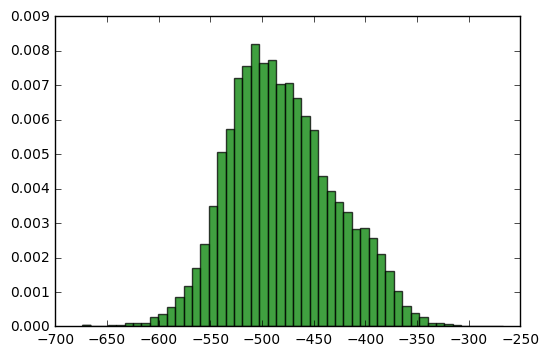

In [19]:
from scipy import stats
stats.describe(acts200)
plt.hist(acts200, 50, normed=1, facecolor='green', alpha=0.75)

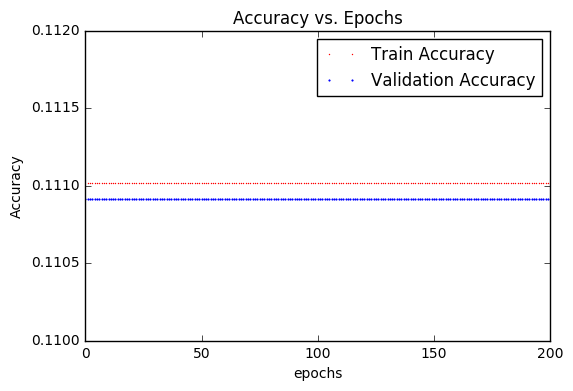

In [73]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
df = pd.DataFrame(h.history)
df['epoch'] =df.index

fig = plt.figure(1)
ax = fig.add_subplot(111)

ax.set_ylim(0.110,0.112)
ax.set_title('Accuracy vs. Epochs')
ax.set_xlabel('epochs')
ax.set_ylabel('Accuracy')

line_train, =ax.plot(np.array(df['epoch']), np.array(df['acc']), '.', color='red', markersize=1)
#plt.plot(x=np.array(df['epoch']), y=np.array(df['acc']), style='o', ylim=(0,1.1), markerfacecolor="None", markeredgecolor='red')
line_val, = ax.plot(np.array(df['epoch']), np.array(df['val_acc']), 'o',  markersize=1, markeredgecolor='blue')
ax.plot(np.array(df['epoch']), np.ones(len(df)), 'black')
ax.legend((line_train, line_val), ('Train Accuracy', 'Validation Accuracy'))
fig.savefig(sub_path + '/train_accuracy_vs_epochs10_base.png')

# Make Pre-Training Work

In [9]:
#Construct a new model with just FCBs and using the convoluation results from Vgg16 as input
#I want to overfit the train data first, so I use 2 dense layers total 4096*4096+4096 (bias) parameters without dropout
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
lr = 0.0001
statefarm_model = Sequential()
#statefarm_model.add(BatchNormalization(axis=1, input_shape=(25088,)))
statefarm_model.add(Dense(256, activation='relu', input_shape=(25088,)))
statefarm_model.add(Dropout(0.5)) 
#statefarm_model.add(Dense(256, activation='relu'))
#statefarm_model.add(Dropout(0.5))
statefarm_model.add(Dense(10, activation='softmax'))
statefarm_model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
statefarm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2570      
Total params: 6,425,354
Trainable params: 6,425,354
Non-trainable params: 0
_________________________________________________________________


In [10]:
from keras.callbacks import ModelCheckpoint
#Need create train batch and validation batch
batch_size = 100

saved_weights_path = weight_path + '/fcn_dropout_epoch_{epoch:02d}-valloss_{val_loss:.2f}.hdf5'
mcp = ModelCheckpoint(saved_weights_path, monitor='val_loss', save_weights_only=True, mode='auto', period=10)
call_backs = [mcp]
epochs = 20
h = statefarm_model.fit(mid_train_data, train_labels, epochs=epochs, validation_data=(mid_val_data, val_labels), batch_size=batch_size, shuffle=True, callbacks=call_backs)

Train on 17943 samples, validate on 4481 samples
Epoch 1/20
17943/17943 [==============================] - 3s 174us/step - loss: 5.5314 - acc: 0.5848 - val_loss: 0.2564 - val_acc: 0.9574
Epoch 2/20
17943/17943 [==============================] - 3s 177us/step - loss: 0.3786 - acc: 0.9136 - val_loss: 0.0611 - val_acc: 0.9844
Epoch 3/20
17943/17943 [==============================] - 3s 177us/step - loss: 0.1739 - acc: 0.9559 - val_loss: 0.0344 - val_acc: 0.9920
Epoch 4/20
17943/17943 [==============================] - 3s 177us/step - loss: 0.1329 - acc: 0.9652 - val_loss: 0.0355 - val_acc: 0.9929
Epoch 5/20
17943/17943 [==============================] - 3s 185us/step - loss: 0.1079 - acc: 0.9722 - val_loss: 0.0252 - val_acc: 0.9940
Epoch 6/20
17943/17943 [==============================] - 3s 187us/step - loss: 0.0905 - acc: 0.9771 - val_loss: 0.0267 - val_acc: 0.9946
Epoch 7/20
17943/17943 [==============================] - 3s 179us/step - loss: 0.0928 - acc: 0.9775 - val_loss: 0.0202 - v

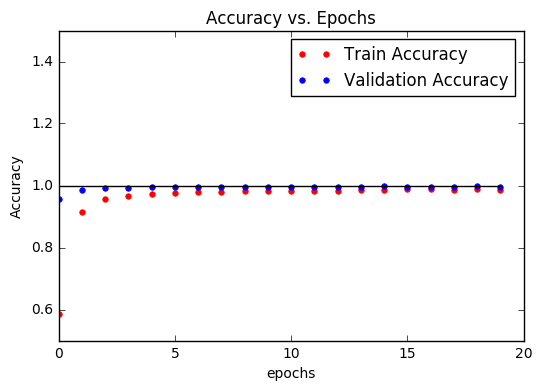

In [17]:

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
df = pd.DataFrame(h.history)
df['epoch'] =df.index

fig = plt.figure(1)
ax = fig.add_subplot(111)

ax.set_ylim(0.5,1.5)
ax.set_title('Accuracy vs. Epochs')
ax.set_xlabel('epochs')
ax.set_ylabel('Accuracy')

line_train, =ax.plot(np.array(df['epoch']), np.array(df['acc']), '.', color='red', markersize=8)
#plt.plot(x=np.array(df['epoch']), y=np.array(df['acc']), style='o', ylim=(0,1.1), markerfacecolor="None", markeredgecolor='red')
line_val, = ax.plot(np.array(df['epoch']), np.array(df['val_acc']), 'o',  markersize=4, markeredgecolor='blue')
ax.plot(np.array(df['epoch']), np.ones(len(df)), 'black')
ax.legend((line_train, line_val), ('Train Accuracy', 'Validation Accuracy'))
fig.savefig(sub_path + '/train_accuracy_vs_epochs10_base.png')


# Check the effects of Learning Rate


In [105]:
val_data.classes
#val_data.__dict__
val_data.samples

50

In [94]:
import vgg16; reload(vgg16)
#vggm.model.save_weights(sub_path + '/sample_epochs200.h5')
vggm = vgg16.Vgg16()
batch_size = 60
vggm.finetune(train_data)
vggm.model.load_weights(sub_path + '/sample_epochs200.h5')
from sklearn.metrics import confusion_matrix
val_batches, val_predictions = vggm.test(val_path, batch_size)

Found 50 images belonging to 10 classes.


In [99]:
from keras import backend as K
from keras.callbacks import ModelCheckpoint
vggm.model.optimizer.get_config()

{'beta_1': 0.8999999761581421,
 'beta_2': 0.9990000128746033,
 'decay': 0.0,
 'epsilon': 1e-08,
 'lr': 0.0010000000474974513}

In [103]:
epochs = 20
lrs = [1.0e-5, 1.0e-4, 1.0e-3, 1.0e-2, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8]
hs = {}
for lr in lrs:
    print("lr = %s"%lr)
    K.set_value(vggm.model.optimizer.lr, lr)
    saved_weights_path = weight_path + '/sample.lr_%6f_epoch_{epoch:02d}-valloss_{val_loss:.2f}.hdf5'%lr
    print(saved_weights_path)
    mcp = ModelCheckpoint(saved_weights_path, monitor='val_loss', save_weights_only=True, mode='auto', period=20)
    call_backs = [mcp]
    h = vggm.fit(train_data, val_data, nb_epoch=epochs, batch_size = batch_size, callbacks=call_backs)
    hs[lr] = h


lr = 1e-05
/home/ubuntu/data/weights/statefarm//sample.lr_0.000010_epoch_{epoch:02d}-valloss_{val_loss:.2f}.hdf5
Epoch 1/20
2/1 [====================================] - 5s 3s/step - loss: 0.0299 - acc: 1.0000 - val_loss: 1.9741 - val_acc: 0.5400
Epoch 2/20
2/1 [====================================] - 5s 2s/step - loss: 0.0680 - acc: 0.9794 - val_loss: 1.9729 - val_acc: 0.5400
Epoch 3/20
2/1 [====================================] - 5s 2s/step - loss: 0.0774 - acc: 0.9589 - val_loss: 1.9718 - val_acc: 0.5400
Epoch 4/20
2/1 [====================================] - 5s 2s/step - loss: 0.0750 - acc: 0.9644 - val_loss: 1.9707 - val_acc: 0.5400
Epoch 5/20
2/1 [====================================] - 5s 2s/step - loss: 0.0237 - acc: 1.0000 - val_loss: 1.9695 - val_acc: 0.5400
Epoch 6/20
2/1 [====================================] - 5s 2s/step - loss: 0.0552 - acc: 0.9706 - val_loss: 1.9685 - val_acc: 0.5600
Epoch 7/20
2/1 [====================================] - 5s 2s/step - loss: 0.0409 - acc: 

KeyboardInterrupt: 

In [8]:
val_preds = [np.argmax(k) for k in val_predictions]
#print(val_predictions[0])
#print(val_batches.classes)
#print(val_preds)
cnf_matrix = confusion_matrix(val_batches.classes, val_preds)
print(cnf_matrix)
test_batches, predictions = val_batches, val_predictions

[[3 0 0 1 0 0 0 0 1 0]
 [2 3 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 1 0]
 [0 1 0 1 0 0 0 0 3 0]
 [0 0 1 0 3 0 0 0 1 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 1 2 0 1 1]
 [0 1 0 0 0 0 0 3 1 0]
 [0 1 0 0 0 2 0 1 1 0]
 [2 0 0 0 0 0 0 0 0 3]]


# Check examples that predicted good, bad, or neutral

In [83]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
weight_path = '/home/ubuntu/data/weights/statefarm/'
lr = 0.001
testm = Sequential()
#testm.add(BatchNormalization(axis=1, input_shape=(25088,)))
testm.add(Dense(1, activation='relu', input_shape=(25088,)))
#testm.add(Dropout(0.5))
#testm.add(Dense(256, activation='relu'))
#testm.add(Dropout(0.5))
testm.add(Dense(10, activation='softmax'))
testm.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
testm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1)                 25089     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                20        
Total params: 25,109
Trainable params: 25,109
Non-trainable params: 0
_________________________________________________________________


In [84]:
wp = weight_path + '/fcn_dropout_epoch_20-valloss_0.03.hdf5'
print(wp)
testm.load_weights(wp)

/home/ubuntu/data/weights/statefarm//fcn_dropout_epoch_20-valloss_0.03.hdf5


In [85]:
from keras.preprocessing import image
batch_size = 100
val_predictions = testm.predict(mid_val_data, batch_size = batch_size)

In [86]:
print(val_labels.shape)
print(val_labels[:10])
print(val_classes.shape)
print(val_classes[:10])
print(len(val_filenames))
print(val_filenames[:10])
print(val_predictions.shape)
print(val_predictions[:10])

(4481, 10)
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
(4481,)
[0 0 0 0 0 0 0 0 0 0]
4481
['c0/img_100456.jpg', 'c0/img_10053.jpg', 'c0/img_100665.jpg', 'c0/img_100824.jpg', 'c0/img_101015.jpg', 'c0/img_101113.jpg', 'c0/img_101175.jpg', 'c0/img_101392.jpg', 'c0/img_101668.jpg', 'c0/img_101673.jpg']
(4481, 10)
[[  1.0000e+00   1.0074e-35   3.6592e-35   1.5745e-39   2.5016e-40   1.1579e-39   0.0000e+00
    0.0000e+00   1.8225e-41   1.8830e-30]
 [  1.0000e+00   1.3239e-25   5.2215e-31   2.4849e-30   2.8033e-39   6.7419e-37   2.8026e-45
    4.2880e-43   1.7881e-42   1.2574e-26]
 [  1.0000e+00   9.7428e-19   8.

In [127]:
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
%matplotlib inline
figsize=(24,12)

def plot_imgs(img_p, filenames, rows = 1, interp=False):
    f = plt.figure(figsize=figsize)
    cols = len(filenames)//rows if len(filenames) % 2 == 0 else len(filenames)//rows + 1
    for i in range(len(filenames)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        sp.set_title(filenames[i], fontsize=16)
        imgpp = img_p + '/' + filenames[i]
        img=mpimg.imread(imgpp)        
        plt.imshow(img, interpolation=None if interp else 'none')
    
    

In [88]:
val_filenames

array([0])

[[  5.6714e-38   2.2173e-27   1.0000e+00   1.9919e-29   1.8367e-39   0.0000e+00   5.7580e-33
    2.8021e-40   5.8146e-27   1.4013e-45]
 [  6.3526e-37   1.3921e-30   1.0000e+00   1.0919e-26   1.7300e-35   0.0000e+00   3.8167e-31
    3.0231e-38   5.5541e-21   5.1995e-41]
 [  5.4664e-34   2.4840e-29   1.0000e+00   9.0227e-30   3.2535e-26   8.0113e-38   1.7309e-28
    4.1134e-31   4.3323e-17   6.7262e-44]
 [  2.4606e-04   3.7260e-06   2.3837e-03   3.1165e-04   2.5900e-11   4.1937e-07   1.9236e-04
    2.7188e-11   9.9686e-01   1.2881e-06]
 [  1.9326e-30   8.3435e-31   1.0000e+00   1.2190e-27   1.4841e-27   9.6854e-33   6.5527e-24
    8.1473e-30   3.6517e-16   5.3109e-43]
 [  2.0968e-39   1.4790e-39   1.0000e+00   3.2079e-41   6.1691e-36   5.0180e-42   2.0571e-26
    5.6133e-31   1.2504e-24   5.0447e-43]
 [  5.1771e-27   7.4411e-34   1.0000e+00   4.2282e-40   1.4279e-42   3.4931e-34   1.5733e-22
    2.2411e-26   3.1256e-26   1.3917e-39]
 [  5.4880e-22   1.0756e-22   1.0000e+00   7.8421e-20  

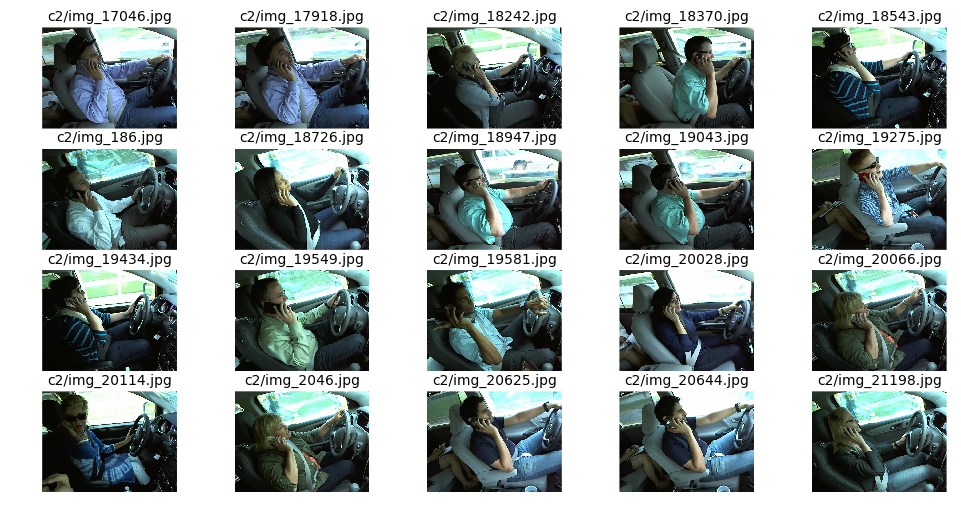

In [89]:
import utils; reload(utils)
from utils import plot, plots, plotgray
val_preds = np.array([np.argmax(k) for k in val_predictions])
#print((next(val_batches)[0].shape))
lr = 1000
hr = 1020
print(val_predictions[lr:hr])
print(val_preds[lr:hr])
print(val_classes[lr:hr])
print(val_labels[lr:hr])
plot_imgs(val_path, val_filenames[lr:hr], rows=4)

In [ ]:
The 10 classes to predict are:

c0: safe driving
c1: texting - right
c2: talking on the phone - right
c3: texting - left
c4: talking on the phone - left
c5: operating the radio
c6: drinking
c7: reaching behind
c8: hair and makeup
c9: talking to passenger


In [119]:
[val_filenames[i] for i in top_5_corrects]

['c3/img_26488.jpg',
 'c3/img_2631.jpg',
 'c3/img_26196.jpg',
 'c3/img_28119.jpg',
 'c9/img_99927.jpg']

# A few examples of correct predictions with high confidence

Max probability for each prediction sorted: 
[4249  948 4211 3873 4273 3902 1323 3048  367 2869 2987 2655  853 4254 2126 4325 3854 3211 3918 1484]
Total correct preds 4464
First correct preds: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Total incorrect preds 17
First Incorrect preds: [103, 367, 1003, 1251, 1323, 1340, 1484, 2503, 2514, 3727, 3918, 3960, 4249, 4254, 4273, 4325, 4478]
Top 5 correct predictions: [1519, 1518, 1517, 1523, 4480]
Top 5 correct predicts: [3 3 3 3 9]
True classes: [3 3 3 3 9]
Pictures that we correctly predicted with high confidence


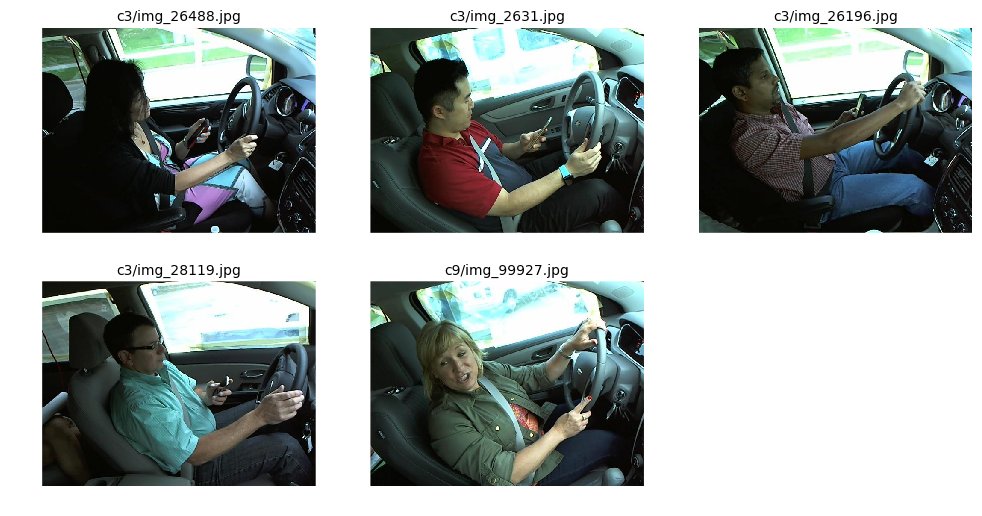

In [121]:
max_val_preds = np.array([max(vp) for vp in val_predictions])
#print(max_val_preds)
sorted_index = np.argsort(max_val_preds) #ascending order
print("Max probability for each prediction sorted: \n%s"%sorted_index[:20])
#print(max_val_preds[[44,21,40, 42, 24, 25]])

pairs = zip(val_preds, val_classes)
correct_preds = [idx for idx, m in enumerate(pairs) if m[0]==m[1]] #indexes for correct predictions
incorrect_preds = [idx for idx, m in enumerate(pairs) if m[0]!=m[1]] #indexes for incorrect predictions
print("Total correct preds %d"%len(correct_preds))
print("First correct preds: %s"%correct_preds[:20])
print("Total incorrect preds %d"%len(incorrect_preds))
print("First Incorrect preds: %s"%incorrect_preds[:20])
top_5_corrects = [si for si in sorted_index[-5:] if si in correct_preds]
print("Top 5 correct predictions: %s"%top_5_corrects)
print("Top 5 correct predicts: %s"%val_preds[top_5_corrects])
print("True classes: %s"%val_classes[top_5_corrects])
print("Pictures that we correctly predicted with high confidence")
plot_imgs(val_path, [val_filenames[i] for i in top_5_corrects], rows=2)

# A few examples of wrong predictions with high confidence

Total incorrect preds 17
First Incorrect preds: [103, 367, 1003, 1251, 1323, 1340, 1484, 2503, 2514, 3727, 3918, 3960, 4249, 4254, 4273, 4325, 4478]
[4249, 4273, 1323, 367, 4254, 4325, 3918, 1484, 103, 1003, 3960, 3727, 2514, 2503, 1251, 4478, 1340]
Top 5 incorrect predicts: [0 8 6 1 8 8 9 0 9 8 9 4 0 0 6 8 1]
True classes:             [9 9 2 0 9 9 8 3 0 2 8 8 5 5 2 9 2]
Pictures that we Incorrectly predicted with high confidence


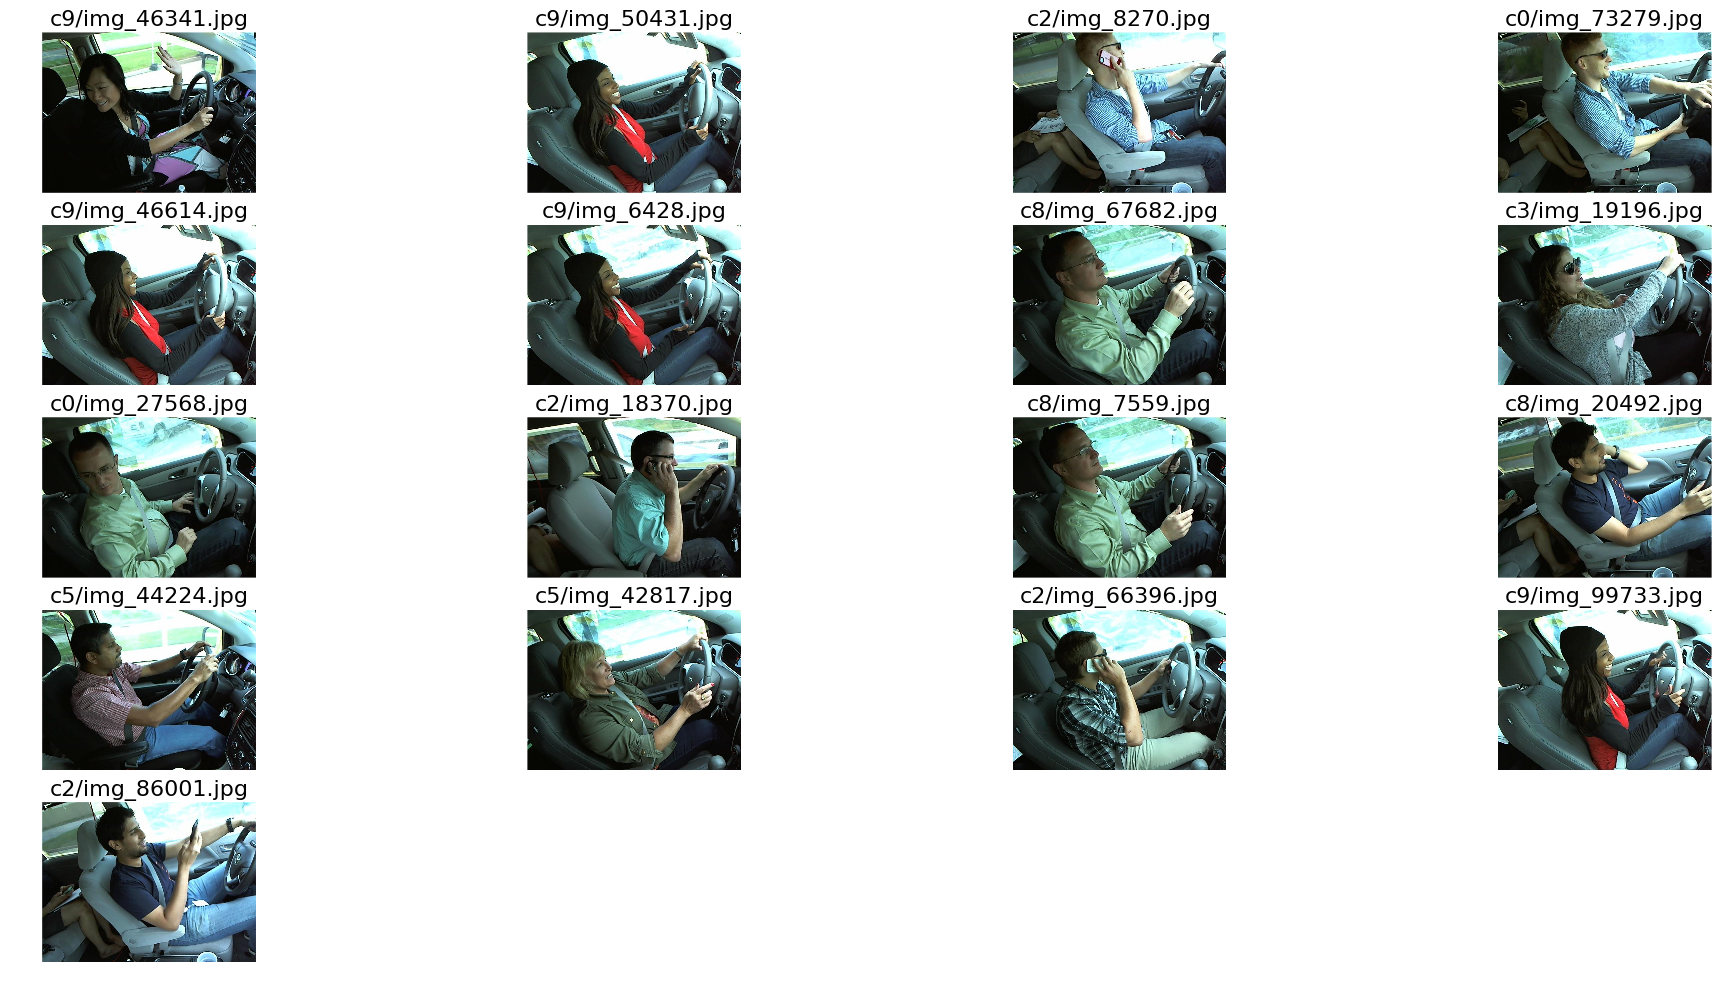

In [129]:
print("Total incorrect preds %d"%len(incorrect_preds))
print("First Incorrect preds: %s"%incorrect_preds[:20])
top_incorrects = [si for si in sorted_index if si in incorrect_preds] #[-17:]
print(top_incorrects)
print("Top 5 incorrect predicts: %s"%val_preds[top_incorrects])
print("True classes:             %s"%val_classes[top_incorrects])
print("Pictures that we Incorrectly predicted with high confidence")
plot_imgs(val_path, [val_filenames[i] for i in top_incorrects], rows=5)

# A Few Random Examples of Correct Predictions

Random 5 correct predicts: [2 9 0 7 0]
True classes: [2 9 0 7 0]
Pictures that we Correctly predicted


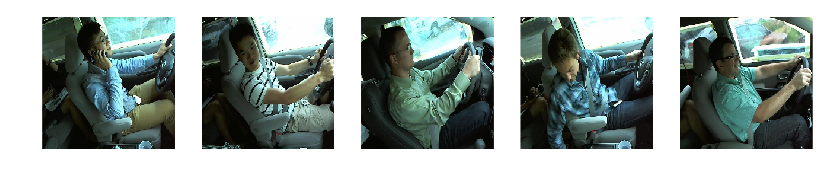

In [73]:
import random
five_corrects = random.sample(correct_preds, 5)
print("Random 5 correct predicts: %s"%val_preds[five_corrects])
print("True classes: %s"%val_batches.classes[five_corrects])
print("Pictures that we Correctly predicted")

plots(next(val_batches)[five_corrects])

# A Few Random Examples of Incorrect Predictions

Random 5 incorrect predicts: [3 1 5 8 8]
True classes: [0 8 8 7 3]
Pictures that we Incorrectly predicted


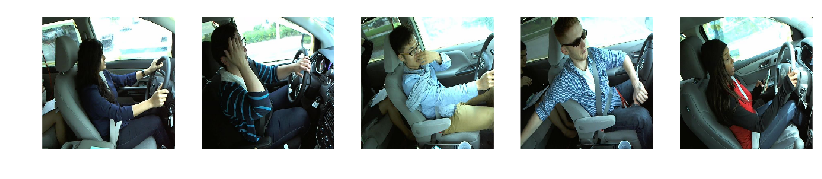

In [74]:
import random
five_incorrects = random.sample(incorrect_preds, 5)
print("Random 5 incorrect predicts: %s"%val_preds[five_incorrects])
print("True classes: %s"%val_batches.classes[five_incorrects])
print("Pictures that we Incorrectly predicted")

plots(next(val_batches)[five_incorrects])

# Examples with probabilities close to each other

Confused indexes: [11, 21, 40, 44]
Confused predictions: [[  3.5329e-05   4.0434e-01   1.4680e-02   1.0490e-03   1.6275e-02   4.9971e-05   1.8890e-03
    2.3638e-04   5.6078e-01   6.5787e-04]
 [  1.3841e-01   3.1891e-04   3.7617e-01   3.7430e-05   2.7578e-01   9.9057e-02   3.1241e-03
    1.0832e-02   5.4598e-02   4.1667e-02]
 [  1.4741e-02   4.2640e-01   1.7430e-02   2.5573e-01   5.2060e-02   5.6424e-02   9.8087e-02
    4.9644e-04   6.7270e-02   1.1363e-02]
 [  6.9515e-03   4.3002e-02   2.2935e-01   4.9439e-04   1.9084e-01   1.4710e-01   1.1928e-01
    2.3950e-01   2.2384e-02   1.0914e-03]]
Confused predicts: [8 2 1 7]
True classes: [2 4 8 8]
Pictures that are confused


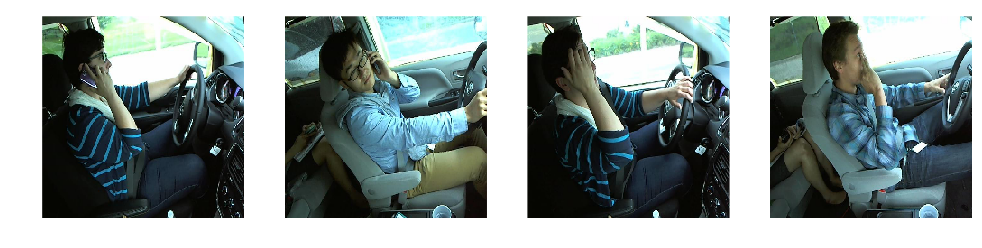

In [87]:
sorted_probs_val_preds = np.array([np.sort(vp) for vp in val_predictions])
#print(val_predictions[:2])
vp = sorted_probs_val_preds[0]
diff_probs_val_preds = [abs(vp[-1]-vp[-2]) for vp in sorted_probs_val_preds]
confused_idx = [idx for idx, p in enumerate(diff_probs_val_preds) if p < 0.2]
print("Confused indexes: %s"%confused_idx)
print("Confused predictions: %s"%val_predictions[confused_idx])
print("Confused predicts: %s"%val_preds[confused_idx])
print("True classes: %s"%val_batches.classes[confused_idx])
print("Pictures that are confused")

plots(next(val_batches)[confused_idx])

In [ ]:
s = test_batches.class_indices.keys()
s.sort()
print(s)
cols = ['img'] + s
print(cols)
dff = pd.DataFrame(predictions, columns=s)
print(dff.head())
print(len(predictions))
print(len(dff))
epochs = 200
print(df.columns.tolist())

In [18]:
test_batches, predictions = vggm.test(test_path, batch_size)

AttributeError: 'Sequential' object has no attribute 'test'

In [19]:
predictions = statefarm_model.predict(mid_test_data, batch_size = batch_size)

In [31]:
predictions[:10]

array([[  3.0603e-24,   8.1034e-31,   5.0861e-27,   3.4799e-24,   2.7721e-21,   1.0000e+00,
          4.4233e-23,   1.5343e-32,   1.7950e-32,   1.7620e-20],
       [  2.0379e-13,   2.2855e-18,   6.7907e-18,   4.2148e-22,   4.5365e-08,   1.0000e+00,
          1.3468e-18,   6.4425e-19,   4.3186e-24,   6.4127e-20],
       [  9.9990e-01,   2.2646e-06,   3.3191e-14,   3.3270e-17,   3.3909e-23,   1.7836e-24,
          8.7432e-18,   2.0015e-26,   2.8459e-12,   9.4558e-05],
       [  4.7924e-43,   2.8026e-45,   1.0542e-27,   7.1074e-42,   3.2206e-24,   4.2039e-45,
          4.7304e-32,   9.9781e-37,   1.0000e+00,   4.0443e-32],
       [  5.3945e-20,   6.6929e-29,   1.4126e-25,   9.9846e-01,   1.5443e-03,   7.5120e-07,
          5.4343e-26,   5.4157e-20,   1.0075e-30,   5.3251e-32],
       [  4.4651e-29,   3.7614e-27,   2.8333e-31,   1.0000e+00,   1.1896e-21,   7.6061e-31,
          9.5420e-39,   3.7091e-38,   8.6072e-33,   4.8472e-33],
       [  3.3038e-35,   2.5409e-36,   1.2319e-35,   4.4530

In [24]:
len(test_batches.filenames)

79726

# Create Submission File

In [33]:
def do_clip(arr, mx): 
    return np.clip(arr, (1-mx)/9, mx)

def get_id(img_path):
    fid = img_path.split("/")[1] #Get image ID
    return fid

s = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'] #train_data.class_indices.keys()
s.sort()
df = pd.DataFrame(predictions, columns=s)
for c in s:
    df[c] = do_clip(df[c], 0.93)
df['img'] = test_filenames #test_batches.filenames
df['img'] = df.apply(lambda r: get_id(r['img']), axis=1)
cols = cols = ['img'] + s
df = df[cols]
#print(df)
fn = "./sub/statefarm/pre_trained_batchsize_" + str(batch_size) + "_epochs" + str(epochs) +"_.csv"
df.to_csv(fn, index=False)
print("Write to " + fn)
print("DONE!")
from IPython.display import FileLink
FileLink(fn)  

Write to ./sub/statefarm/pre_trained_batchsize_100_epochs20_.csv
DONE!


/home/ubuntu/fastai_course/neilz/part1/sub/statefarm/pre_trained_batchsize_100_epochs20_.csv